In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('81d728917f2d49de87863c093eb7a553')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [2]:
crop_data = pd.read_csv("crop_data.csv")

In [3]:
crop_data = crop_data[['vh','vv','Class of Land']]
crop_data.head()

,vh,vv,Class of Land
0,0.065339,0.137559,Rice
1,0.029045,0.103210,Rice
2,0.056547,0.279272,Rice
3,0.035070,0.154607,Rice
4,0.041903,0.191198,Rice


In [4]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,stratify=y,random_state=40)

In [5]:
# evaluate knn on the sonar dataset with minmax scaler transform
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

In [6]:
from sklearn.neural_network import MLPClassifier
# Neural Network Classifier
model = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)

In [7]:
insample_predictions = model.predict(X_train)

In [8]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 78.33%
              precision    recall  f1-score   support

    Non Rice       0.81      0.77      0.79       159
        Rice       0.75      0.80      0.78       141

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300



In [9]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

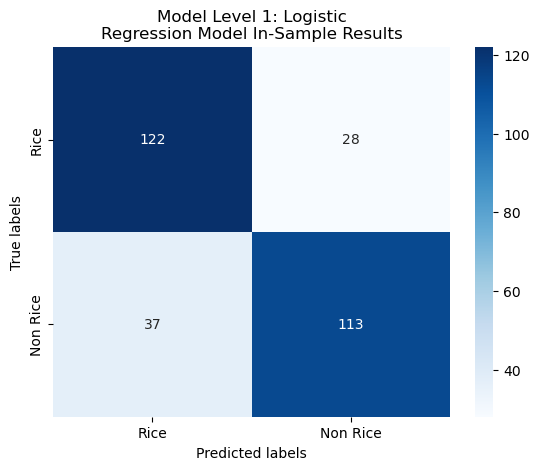

In [10]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

In [11]:
outsample_predictions = model.predict(X_test)

In [12]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 75.67%
              precision    recall  f1-score   support

    Non Rice       0.74      0.80      0.77       150
        Rice       0.78      0.71      0.75       150

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300



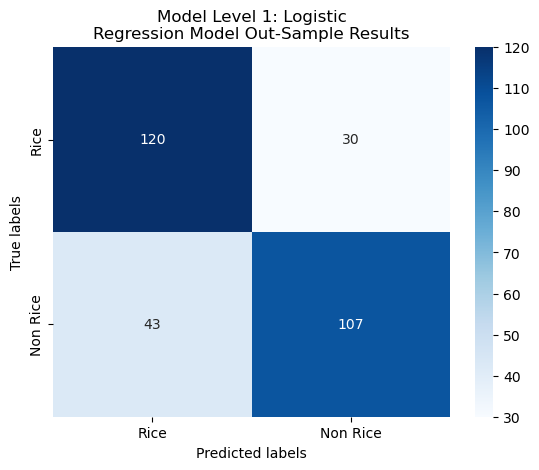

In [13]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

In [14]:
submission_vh_vv_data = pd.read_csv("submission_vh_vv.csv")
submission_vh_vv_data.head()

,vh,vv
0,0.003928,0.048405
1,0.016505,0.124807
2,0.036922,0.093570
3,0.002008,0.010407
4,0.063200,0.205140


In [15]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = mm.transform(submission_vh_vv_data)

In [16]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [17]:
#Combining the results into dataframe 
submission_df = pd.DataFrame({'id':test_file['Latitude and Longitude'].values, 'target':final_prediction_series.values})

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
#Displaying the sample submission dataframe
display(submission_df)

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [38]:
#Dumping the predictions into a csv file.
submission_df.to_csv("challenge_1_submission3_rice_crop_prediction.csv",index = False)